In [1]:
from sklearn import datasets
import numpy as np

iris_data = datasets.load_iris()
X = iris_data["data"]
y = iris_data["target"]

np.count_nonzero(y == 0), np.count_nonzero(y == 1), np.count_nonzero(y == 2)

(50, 50, 50)

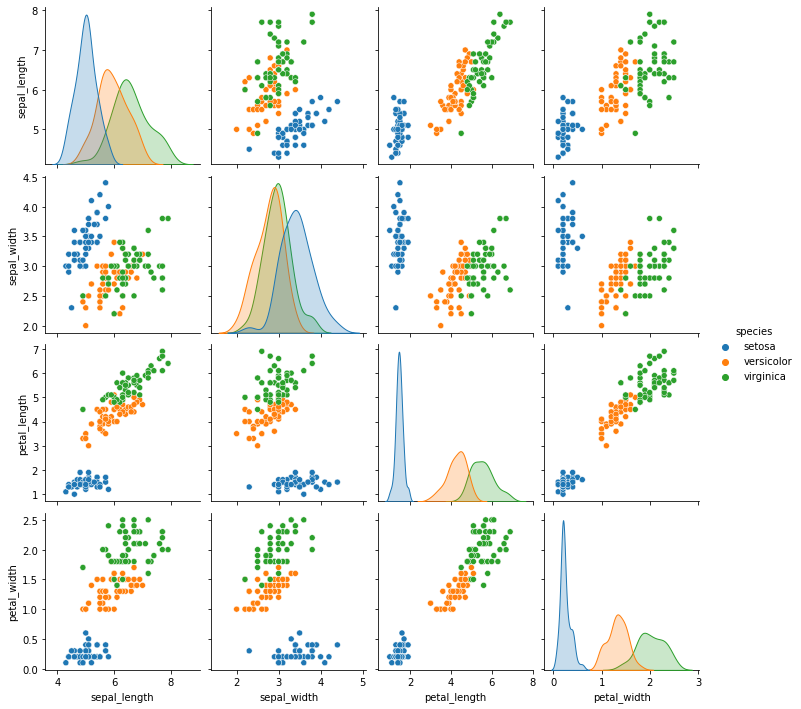

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()
iris_df = sns.load_dataset("iris")

# Display pairplot
sns.pairplot(iris_df, hue="species", height=2.5)
plt.show()

In [3]:
import random
from numpy.typing import NDArray


def train_test_split(X: NDArray, y: NDArray, test_size=0.2, random_state=None):
    if random_state:
        random.seed(random_state)
    dataset = list(zip(X, y))
    random.shuffle(dataset)
    test_size_index = int(len(dataset) * test_size)
    X_test, y_test = zip(*dataset[:test_size_index])
    X_train, y_train = zip(*dataset[test_size_index:])

    return (
        np.asarray(X_train),
        np.asarray(X_test),
        np.asarray(y_train),
        np.asarray(y_test),
    )

In [4]:
from model import Perceptron
from training import fit_perceptron
from prediction import one_vs_all

In [5]:
import numpy as np


def transform_to_one_vs_all_labels(y: NDArray, target_class: int) -> NDArray:
    one_vs_all_labels = np.zeros_like(y)
    one_vs_all_labels[y == target_class] = 1
    return one_vs_all_labels

In [6]:
classes = [0, 1, 2]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
y_targeted_dict = {
    target_class: [
        transform_to_one_vs_all_labels(y_train, target_class),
        transform_to_one_vs_all_labels(y_test, target_class),
    ]
    for target_class in classes
}

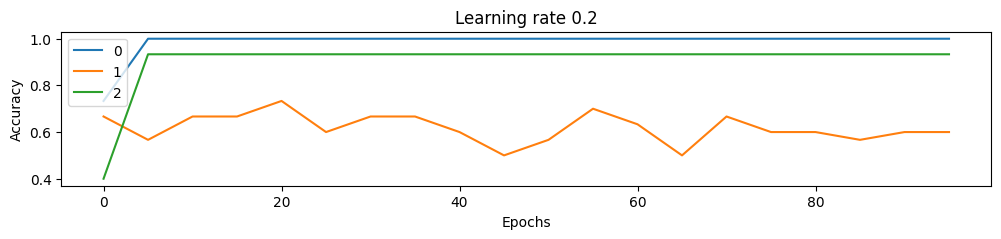

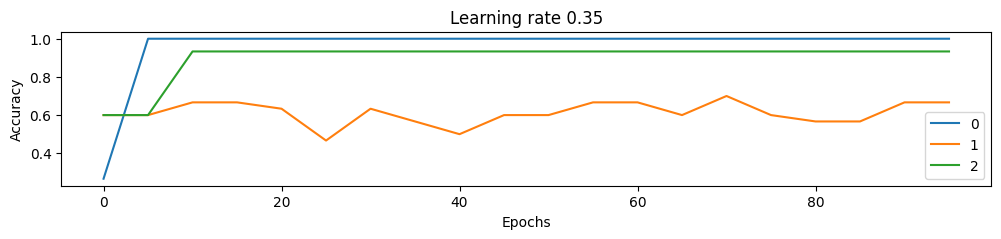

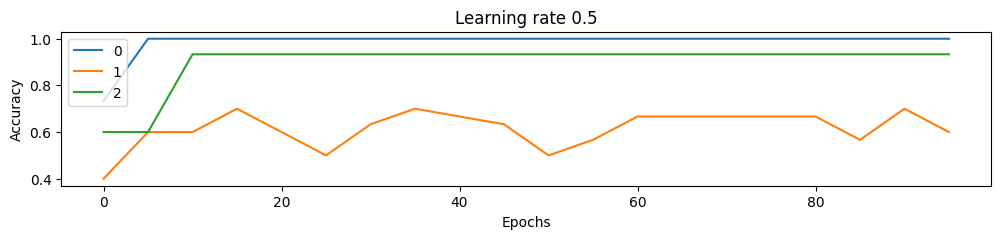

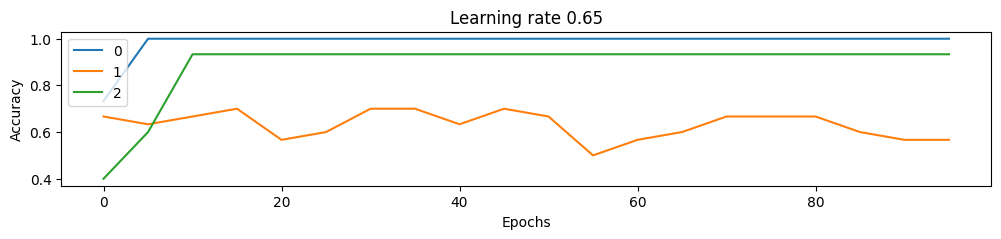

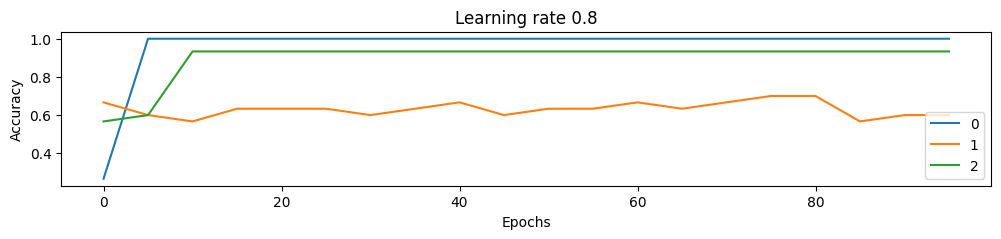

In [7]:
import matplotlib.pyplot as plt


def get_accuracy_maps(learning_rate: float) -> dict[int, dict[int, float]]:

    accuracy_maps = {}

    for epochs in range(0, 100, 5):
        accuracy_map = {key: 0 for key in classes}
        for target_class in classes:
            y_train_targeted, y_test_targeted = y_targeted_dict[target_class]
            perception = fit_perceptron(
                X_train, y_train_targeted, epochs, learning_rate
            )
            correct_guesses = 0
            total_targets = len(X_test)
            for (test_input, test_target) in zip(X_test, y_test_targeted):
                predicted, _ = perception.predict(test_input)
                if predicted == test_target:
                    correct_guesses += 1

            accuracy_map[target_class] = correct_guesses / total_targets
        accuracy_maps[epochs] = accuracy_map

    return accuracy_maps


def plot_accuracy(accuracy_dict: dict[int, dict[int, float]], learning_rate: float):
    epochs = list(accuracy_dict.keys())
    classes = list(accuracy_dict[epochs[0]].keys())

    plt.figure(figsize=(12, 2))

    for class_name in classes:
        accuracies = [accuracy_dict[epoch][class_name] for epoch in epochs]
        plt.plot(epochs, accuracies, label=class_name)

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Learning rate {learning_rate}")
    plt.legend()
    plt.show()


learning_rate = 0.2
while learning_rate < 0.9:
    plot_accuracy(get_accuracy_maps(learning_rate), learning_rate)
    learning_rate += 0.15

In [8]:
perception_0 = fit_perceptron(
    X_train, y_targeted_dict[0][0], epochs=8, learning_rate=0.40
)
perception_1 = fit_perceptron(
    X_train, y_targeted_dict[1][0], epochs=8, learning_rate=0.40
)
perception_2 = fit_perceptron(
    X_train, y_targeted_dict[2][0], epochs=8, learning_rate=0.40
)

iris_perceptions = perception_0, perception_1, perception_2

In [9]:
perception_0.weights, perception_0.bias

(array([ 0.79657515,  1.90971128, -2.7481247 , -1.30004284]), array([0.4]))

In [10]:
predicted_labels = []
correct_labels = []

for index in range(len(X_test)):
    sample, correct_label = X_test[index], y_test[index]
    prediction = one_vs_all(*iris_perceptions, sample)

    predicted_labels.append(prediction)
    correct_labels.append(correct_label)

{-3.938974953428874: {'id': 0, 'prediction': 0}, -6.675044628141628: {'id': 1, 'prediction': 0}, -5.396245335631154: {'id': 2, 'prediction': 0}}
{-5.199885215428657: {'id': 0, 'prediction': 0}, -5.142058758714204: {'id': 1, 'prediction': 0}, 0.8136089993992153: {'id': 2, 'prediction': 1}}
{-7.003366097993543: {'id': 0, 'prediction': 0}, -15.81399674220286: {'id': 1, 'prediction': 0}, 10.038517647628368: {'id': 2, 'prediction': 1}}
{-6.985200567938191: {'id': 0, 'prediction': 0}, -2.3513659359385644: {'id': 1, 'prediction': 0}, 10.922211406256277: {'id': 2, 'prediction': 1}}
{-2.525278840180539: {'id': 0, 'prediction': 0}, -6.4949922370479: {'id': 1, 'prediction': 0}, -15.314245393831516: {'id': 2, 'prediction': 0}}
{-2.663260788595696: {'id': 0, 'prediction': 0}, -9.759920173080037: {'id': 1, 'prediction': 0}, -10.88059731712626: {'id': 2, 'prediction': 0}}
{-7.59179438681409: {'id': 0, 'prediction': 0}, -2.9254809199757537: {'id': 1, 'prediction': 0}, 10.004068805109664: {'id': 2, 'pr

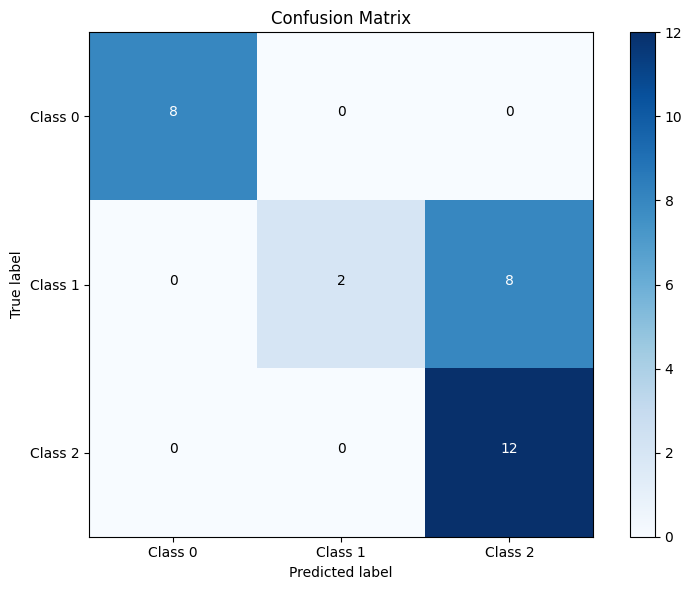

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(correct_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ["Class 0", "Class 1", "Class 2"])
plt.yticks(tick_marks, ["Class 0", "Class 1", "Class 2"])

# Add labels to each cell
for i in range(3):
    for j in range(3):
        plt.text(
            j,
            i,
            format(cm[i, j], "d"),
            horizontalalignment="center",
            color="white" if cm[i, j] > cm.max() / 2 else "black",
        )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()